In [17]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import sys
path = os.getcwd()
f_path, _ = os.path.split(path)
sys.path.insert(0, f_path)
print(f_path)
import lightgbm as lgb
from datetime import datetime
from sklearn.linear_model import LinearRegression
# from dmatrix2np import dmatrix_to_numpy
# from sklearn.datasets import load_svmlight_file
# import math
# from dmatrix2np import dmatrix_to_numpy
# from sklearn.datasets import load_svmlight_file
# import xgboost as xgb
# import pdb
from src.featurizers import *
from src.feature_ensemblers import *
from src.evaluation import *
from ETLoss.ETL import *
from adtk.detector import PersistAD


/Users/maziqing/PycharmProjects/SaDI/code


## Load data

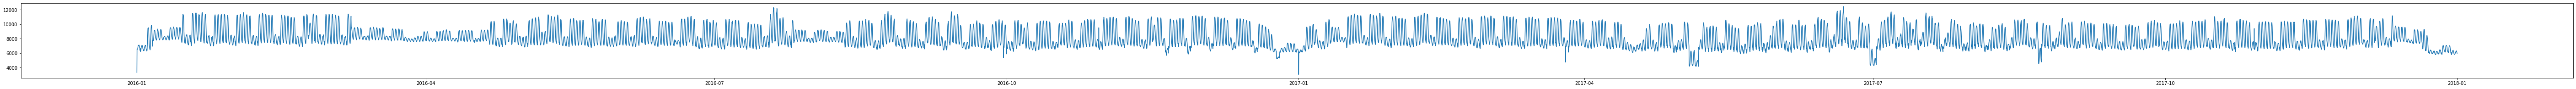

In [10]:
df = pd.read_csv('../../data/public_dataset/Robin_20160101_20171231_15T.csv', 
                 parse_dates=['dt']).set_index('dt')
plt.figure(figsize=(100,3))
plt.plot(df['load'])

## Data pre-process

In [11]:
x = df['load']
persist_ad = PersistAD()
anomalies = persist_ad.fit_detect(df['load'])
df.loc[anomalies==True,'load']=np.nan
x = x.interpolate()

## Feature engineering

In [12]:
# feature engineering
datefea = DateTimeFeaturizer(feature_col=['index_15min', 'year', 'day', 'day_of_year',
                                                                          'day_of_year_sin', 'day_of_year_cos',
                                                                          'month', 'day_of_month_sin',
                                                                          'day_of_month_cos',
                                                                          'day_of_week', 'is_weekend',
                                                                          'day_of_week_sin',
                                                                          'day_of_week_cos', 'hour',
                                                                          'is_special_workday',
                                                                          'is_special_holiday'])
difffea = DifferenceFeaturizer(offsets=192,
                               feature_col=['airTemperature', 'cloudCoverage', 
                                            'dewTemperature', 'precipDepth1HR',
                                            'precipDepth6HR', 'seaLvlPressure', 'windDirection', 'windSpeed'])

rfea1 = RollingStatsFeaturizer(offsets=192,
                               feature_col=['load'], wins=[1, 7],
                               quantiles=[0.25, 0.75])
rfea2 = RollingStatsFeaturizer(offsets=192,
                               wins=[7, 14],
                               quantiles=[0.25, 0.75],
                               feature_col=['load'],
                               is_interval=True)
feature_ensembler = FeatureEnsembler(featurizers=[datefea, difffea, rfea1, rfea2])


## define prediction function

In [13]:
def pred_one_component(feature_en, df, feature_engi=True, diff=False, model='lgb', xslice='all', max_depth=10):
    # choose to do feautre engineering or not
    if feature_engi:
        dffea = feature_en.transform(df)
    else:
        dffea = df
    dffea2 = dffea.copy()
    
    # choose to predict differencing or not
    if diff:
        Y_ori = dffea['load'].copy()
        dffea2 = dffea.copy()
        dffea2['load'] = (dffea2['load'] - dffea2['load'].shift(192))
    Y = dffea2.pop('load')
    X = dffea2
    
    # choose split mode: 'summer' or 'all'
    split1 = datetime(2017,6,1,0,15)
    split2 = datetime(2017,7,1,0,15)
    
    if xslice == 'summer':
        slice0 = slice(datetime(2016,6,1), datetime(2016,9,1))
        slice1 = slice(datetime(2017,6,1), datetime(2017,7,1))
        X_train = pd.concat([X[slice0], X[slice1]])
        Y_train = pd.concat([Y[slice0], Y[slice1]])
        
    elif xslice == 'all':
        split0 = datetime(2016,2,10,0,15)
        X_train = X[split0:split1]
        Y_train = Y[split0:split1]   
    
    X_valid = X[split1: split2]
    X_test = X[split2:]
    
    Y_valid = Y[split1: split2]
    Y_test = Y[split2:]
    
    X_train = X_train.interpolate(limit_direction='both').fillna(0)
    Y_train = Y_train.interpolate(limit_direction='both').fillna(0)
    X_valid = X_valid.interpolate(limit_direction='both').fillna(0)
    X_test = X_test.interpolate(limit_direction='both').fillna(0)
    
    train_params = {
                    'params': {
                        'num_threads': 12,
                        'learning_rate': 0.02,
                        'boosting_type': 'gbdt',
                        'objective': 'regression',
                        'metric': 'mae',
                        'num_leaves': 45,
                        'min_data_in_leaf': 60,
                        'feature_fraction': 0.9,
                        'bagging_fraction': 0.9,
                        'bagging_freq': 1,
                        'seed': 16,
                        'verbosity': -1,
                        'max_bins': 300,
                        'num_iterations': 5000,
                        'max_depth': max_depth
                    },
                    'callbacks': [
                        lgb.log_evaluation(500)
                    ],
                    'early_stopping_rounds': 2000
                }
    
    if model == 'lgb':
        train_set = lgb.Dataset(X_train, Y_train)
        valid_sets = [train_set, lgb.Dataset(X_valid, Y_valid)]
        model = lgb.train(train_set=train_set, valid_sets=valid_sets, **train_params)
        if diff:
            Y_pred = pd.DataFrame({'load': model.predict(X_test)}, 
                                  index=Y_test.index) + Y_ori.shift(192)[Y_test.index].to_frame()
            Y_test = Y_ori[Y_test.index]
        else:
            Y_pred = pd.DataFrame({'load': model.predict(X_test)}, index=Y_test.index)
            
    elif model == 'linear':
        model = LinearRegression()
        model.fit(X_train, Y_train)
        Y_pred = pd.DataFrame({'load': model.predict(X_test)}, index=Y_test.index)
        
    elif model == 'evloss':
        train_set = lgb.Dataset(X_train, Y_train, free_raw_data=False)
        valid_sets = [train_set, lgb.Dataset(X_valid, Y_valid, free_raw_data=False)]
        model = lgb.train(train_set=train_set, valid_sets=valid_sets, **train_params,
                         fobj=my_closure_lgb1,
                         feval=my_closure_lgb2)
        Y_pred = pd.DataFrame({'load': model.predict(X_test)}, index=Y_test.index)
        
        
        
    Y_pred_train = pd.DataFrame({'load': model.predict(X_train)}, index=Y_train.index)
#     plt.figure(figsize=(30,3))
#     plt.plot(Y_pred_train)
#     plt.plot(Y_train)
#     plt.plot(Y_test)
#     plt.plot(Y_pred)
#     plt.legend(['pred', 'true', 'true', 'pred'])
    return Y_pred, Y_test



## Start predict

In [18]:
# target column = 'load'
# get long-term trend (or yearly trend)
dfyt = df.copy()
dfyt['load'] = dfyt['load'].rolling(96*30*12, min_periods=1).mean().interpolate(limit_direction='both')
res = (df['load'] - dfyt['load']).to_frame()

# get short-term trend
dft = df.rolling(96).mean().copy()
dft['load'] = (res['load'].rolling(96).mean()).to_frame().interpolate(limit_direction='both')

# get periodic 
dfs = df.copy()
dfs['load'] = (res['load'] - dft['load']).to_frame().interpolate(limit_direction='both')

# predict dfyt, dft, dfs individually
Y_pred1, Y_test1 = pred_one_component(feature_ensembler, dfyt, feature_engi=True, diff=False, model='linear', xslice='all')

Y_pred2, Y_test2 = pred_one_component(feature_ensembler, dft, feature_engi=True, 
                             diff=False, model='evloss', xslice='all', max_depth=1)

Y_pred3, Y_test3 = pred_one_component(feature_ensembler, dfs, feature_engi=True, 
                             diff=True, model='lgb', xslice='all')

Y_pred = Y_pred1.rename(columns={'load':0}) + Y_pred2.rename(columns={'load':0}) + Y_pred3.rename(columns={'load':0})
Y_test = Y_test1 + Y_test2[Y_test1.index] + Y_test3

print('='*10+' results '+'='*10)
print('daily_mean_rmse={}'.format(get_acc(Y_pred.values, Y_test.to_frame().values)))
print('daily_mean_mape={}'.format(get_mape(Y_pred.values, Y_test.to_frame().values)))
    

/Users/maziqing/opt/anaconda3/envs/py37_sklearn/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/maziqing/opt/anaconda3/envs/py37_sklearn/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	training's l1: 311.175	training's T_loss: 174319	valid_1's l1: 417.733	valid_1's T_loss: 308925
[1000]	training's l1: 281.986	training's T_loss: 147692	valid_1's l1: 394.488	valid_1's T_loss: 283915
[1500]	training's l1: 270.015	training's T_loss: 134586	valid_1's l1: 391.72	valid_1's T_loss: 281846
[2000]	training's l1: 261.825	training's T_loss: 125879	valid_1's l1: 391.936	valid_1's T_loss: 283138
[2500]	training's l1: 255.157	training's T_loss: 119376	valid_1's l1: 391.471	valid_1's T_loss: 285208
[3000]	training's l1: 250.076	training's T_loss: 114266	valid_1's l1: 391.257	valid_1's T_loss: 286535


/Users/maziqing/opt/anaconda3/envs/py37_sklearn/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/maziqing/opt/anaconda3/envs/py37_sklearn/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	training's l1: 93.3578	valid_1's l1: 257.85
[1000]	training's l1: 61.5811	valid_1's l1: 258.232
[1500]	training's l1: 46.7326	valid_1's l1: 258.449
[2000]	training's l1: 38.0187	valid_1's l1: 258.378
[2500]	training's l1: 32.2484	valid_1's l1: 257.768
========== results ==========
daily_mean_rmse=0.05673050366862224
daily_mean_mape=0.050172577346505716
